- divides domain into 4 regions (N. Strait, S. Strait, Haro, JdF)
- plots all stns from grl_2016 edit
- calculates oxygen relationships from salinity
- initializes an nc file with these relationships

Only considers relationship between oxygen and salinity when salinity >26


In [28]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [29]:
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp
import cmocean
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

%matplotlib inline


In [30]:
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

tmask = mesh.variables['tmask'][0, :, :, :]
tmask = np.abs(tmask-1)
mesh.close()

#

## Loading an initial file - 12 sep 16, sea_initial

In [31]:
ds2 = nc.Dataset('/data/tjarniko/MEOPAR/SS-run-sets/SalishSea/nemo3.6/tereza/INIT_NC/init_DICTAOXY_May04.nc')
print(ds2)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): y(898), x(398), deptht(40), time_counter(1)
    variables(dimensions): float32 tn(time_counter,deptht,y,x), float32 sn(time_counter,deptht,y,x), float32 TRNDON(time_counter,deptht,y,x), float32 TRNMICZ(time_counter,deptht,y,x), float32 TRNMYRI(time_counter,deptht,y,x), float32 TRNNH4(time_counter,deptht,y,x), float32 TRNNO3(time_counter,deptht,y,x), float32 TRNTRA(time_counter,deptht,y,x), float32 TRNPHY(time_counter,deptht,y,x), float32 TRNDIAT(time_counter,deptht,y,x), float32 TRNPON(time_counter,deptht,y,x), float32 TRNSi(time_counter,deptht,y,x), float32 TRNbSi(time_counter,deptht,y,x), float32 TRNDIC(time_counter,deptht,y,x), float32 TRNTA(time_counter,deptht,y,x), float64 TRNO2(time_counter,deptht,y,x)
    groups: 



In [32]:
sal = ds2.variables['sn']
sal_masked = np.ma.masked_array(sal, mask=tmask)
sal1 = sal_masked[0,0,:,:]
temp = ds2.variables['tn']
temp_masked = np.ma.masked_array(temp, mask=tmask)

temp1 = temp_masked[0,0,:,:]
temp_all = temp_masked[:,:,:,:]
surfmask = np.zeros_like(temp1)
deepmask = np.zeros_like(temp_all)
surfmask[temp1>0] = 4
deepmask[temp_all>0] =4

for y in range(0,898):
    for x in range(0,398):
        q = temp1[y,x]
        q = np.uint64(q)
        
        if  (x <200) & (y>220) & (y<500) & (q >0) :
            deepmask[:,:,y,x] = 1
        if  (y >= 550) & (q > 0):
            deepmask[:,:,y,x] = 2
        if (x> 150) & (y>310) & (y<550) & (q>0):
            deepmask[:,:,y,x] = 3

deepmask[temp_all==0] = 0

In [33]:
deepmask[:,:,250,200]

masked_array(data =
 [[4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0
  4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0]],
             mask =
 [[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False]],
       fill_value = 1e+20)

## rough mask of water regions defined in Ianson (Haro, JdF, N. Strait, S. Strait) to use for assigning salinity relationships - to be refined...

In [34]:

for y in range(0,898):
    for x in range(0,398):
        q = temp1[y,x]
        q = np.uint64(q)
        
        if  (x <200) & (y>220) & (y<500) & (q >0) :
            surfmask[y,x] = 1
        if  (y >= 550) & (q > 0):
            surfmask[y,x] = 2
        if (x> 150) & (y>310) & (y<550) & (q>0):
            surfmask[y,x] = 3



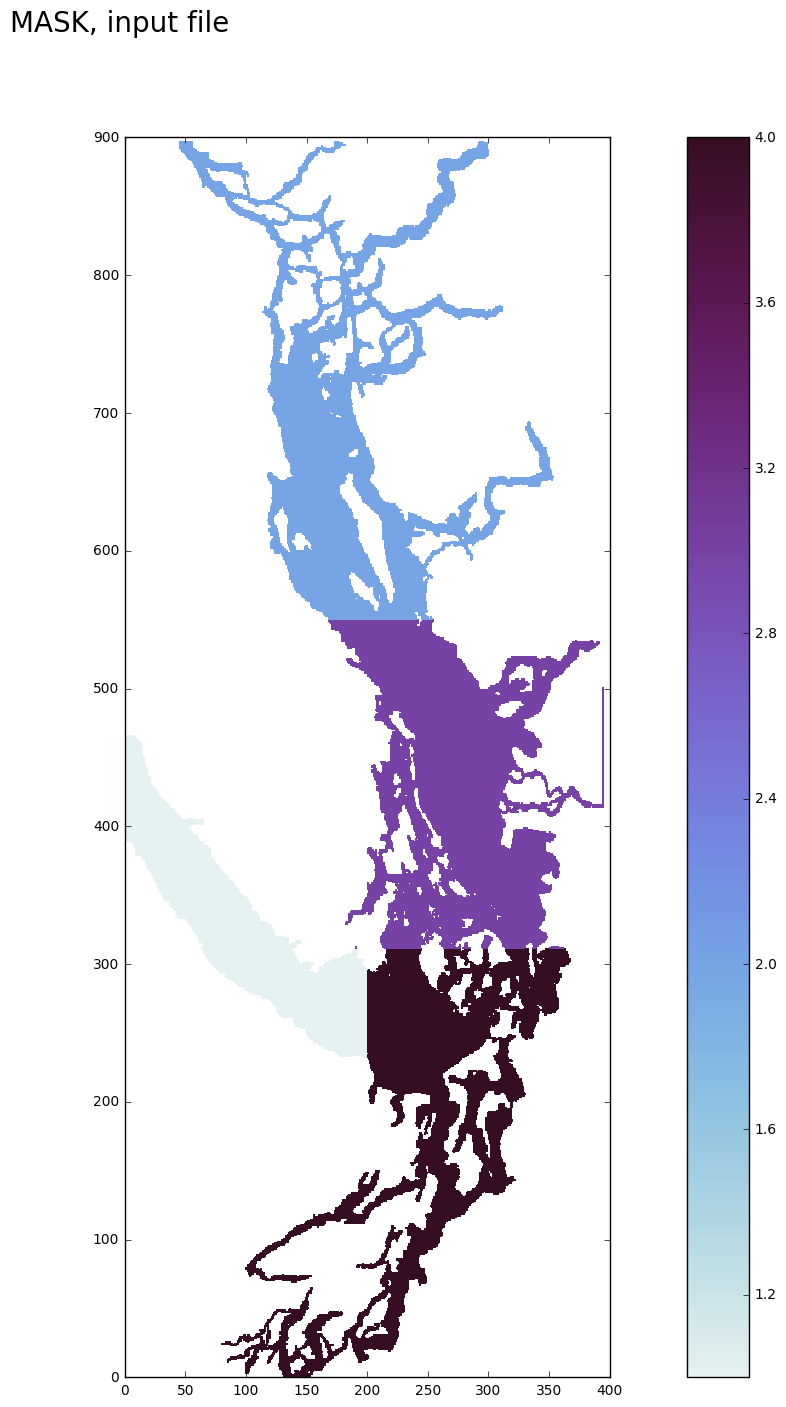

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(20, 16))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(surfmask, cmap=cmocean.cm.dense)
fig.colorbar(mesh)
plt.suptitle('MASK, input file',fontsize=20)

## Loading data from Debby, some edits to loc. of station 39.5, 42, 12

In [36]:
infil = loadtxt('../DATASETS/grl2016_edit2.txt')

In [37]:
crid= infil[:,0]
ln = infil[:,2]
stn = infil[:,3]
lat = infil[:,6]
lon = infil[:,7]
P = infil[:,8]
T = infil[:,9]
S = infil[:,10]
ox = infil[:,11]
ox_qf = infil[:,12]
dic = infil[:,13]
alk = infil[:,15]
dic_qf = infil[:,14]
alk_qf = infil[:,16]
no3 = infil[:,17]
no3_qf = infil[:,18]
si = infil[:,19]
si_qf = infil[:, 20]
po4 = infil[:,21]
po4_qf = infil[:, 22]



## Plotting station points over bathymetry

In [38]:
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')

nav_lon = mesh.variables['nav_lon'][:]
nav_lat = mesh.variables['nav_lat'][:]
bathy = mesh.variables['Bathymetry'][:]

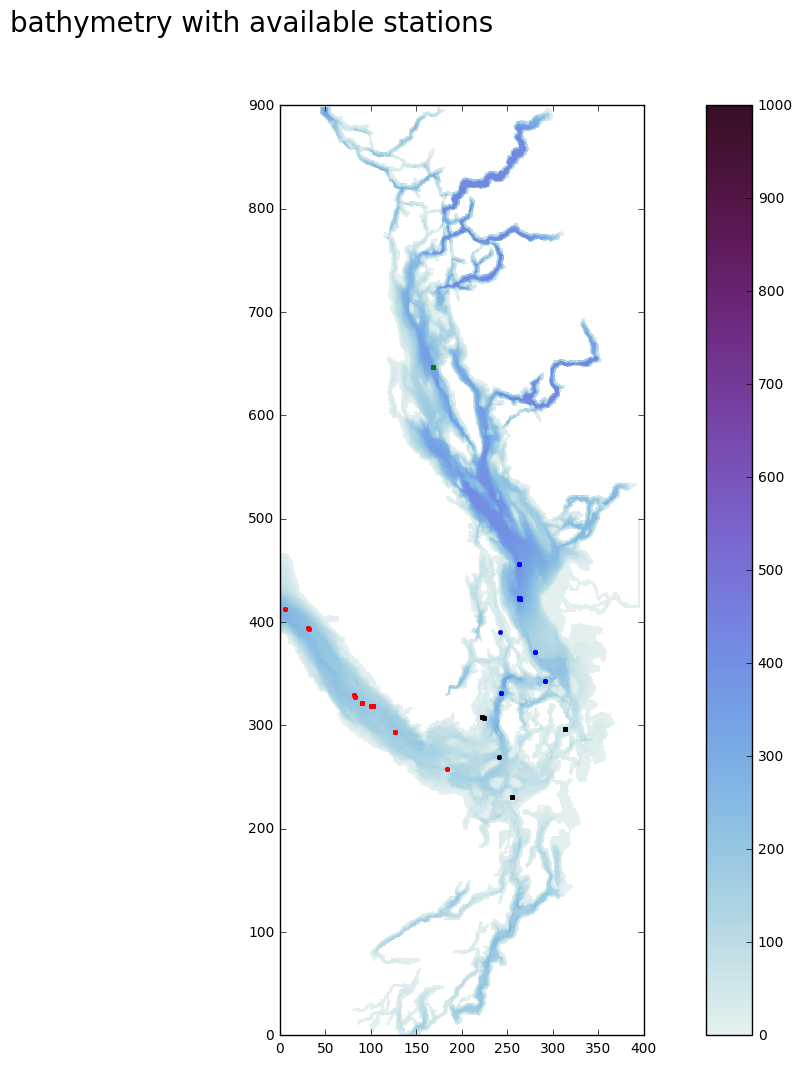

In [39]:
tag = infil[:,0]
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(bathy, cmap=cmocean.cm.dense, vmin = 0, vmax = 1000)
for w in range(0,860):
    j, i = geo_tools.find_closest_model_point(lon[w],lat[w],nav_lon,nav_lat)

    #JdF
    if  (i <200) & (j>220) & (j<500)  :
        tag[w] = 1
        ax.plot(i,j,'r.')
    #northern Strait
    if  (j >= 550) :
        tag[w] = 2
        ax.plot(i,j,'g.')
    # southern Strait    
    if (i> 150) & (j>310) & (j<550) :
        tag[w] = 3
        ax.plot(i,j,'b.')
        #puget
    if(i>=200) & (j<= 310):
        tag[w] = 4
        ax.plot(i,j,'k.')

    #ax.plot(i,j,'r.')
fig.colorbar(mesh)
plt.suptitle('bathymetry with available stations',fontsize=20)



## For each region, calculating linear relationship parameters for OX

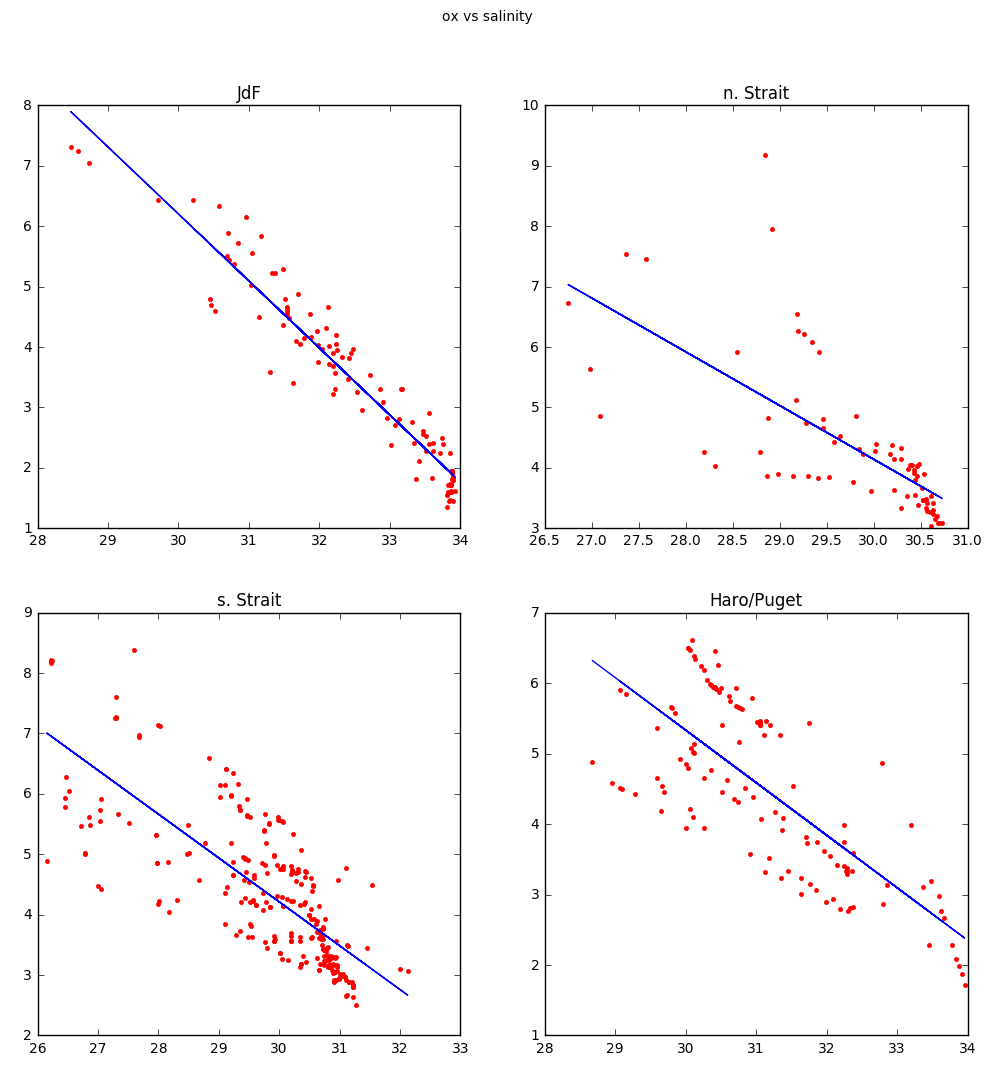

slopes:
[-1.1093358620615621, -0.88960893171423927, -0.72610938589358809, -0.74540955174472656]
intercepts:
[39.482801413558569, 30.829406509621478, 25.996793064314204, 27.695179997365347]
ox at 26
[10.640068999957954, 7.6995742850512556, 7.117949031080915, 8.3145316520024579]


In [40]:
from scipy import stats 
slopes_ox = [0,0,0,0]
ints_ox = [0,0,0,0]
oxs_at_26 = [0,0,0,0]
smalltit = ['JdF','n. Strait', 's. Strait', 'Haro/Puget']
fig, big_axes = plt.subplots( figsize=(12.0, 12.0) , nrows=3, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.tick_params(labelcolor=(1.,1.,1., 1.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False
    
for i in range(1,5):
        
    ax = fig.add_subplot(2,2,i)
    idx = np.where(tag == i )
    S_toplot = S[idx]
    ox_toplot = ox[idx]
    #print(ox_toplot)
    idx_n = np.where(np.isfinite(ox_toplot) & np.greater_equal(S_toplot,26))
    #print(idx_n)
    S_nn = S_toplot[idx_n]
    ox_nn = ox_toplot[idx_n]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(S_nn,ox_nn)
    line = slope*S_nn+intercept
    oxs_at_26[i-1] = slope*26+intercept
    slopes_ox[i-1] = slope
    ints_ox[i-1] = intercept
    ax.plot(S_nn,ox_nn,'r.')
    ax.plot(S_nn,line,'-b')
    tit = smalltit[i-1]
    ax.set_title(tit)
    
    
fig.set_facecolor('w')
plt.suptitle('ox vs salinity')
plt.show()

print('slopes:')
print(slopes_ox)
print('intercepts:')
print(ints_ox)
print('ox at 26')
print(oxs_at_26)

## Creating 3d regional mask, parameterizing OX on whole domain according to slopes/intercepts above


In [41]:

sal2 = sal[:]
OX = sal[:]



for i in range(1,5):
        
    OX_masked = np.ma.masked_array(OX, mask=tmask)
    ind1 = np.where((deepmask==i) & (sal2 >= 26))
    ind2 = np.where((deepmask==i) & (sal2 < 26))
    ts = slopes_ox[i-1]
    ti = ints_ox[i-1]
    thres_ox = oxs_at_26[i-1]
    OX_masked[ind1] = sal2[ind1]*ts + ti
    OX_masked[ind2] = thres_ox
    #conv to umol/L

OX_masked[:] = OX_masked[:]*44.6596
    #OX_masked[(OX_masked == 0) & (salm != 60)] = 7.117949031080915 

OX_masked[0,:,250,250]

masked_array(data = [215.2782440185547 215.2782440185547 215.2782440185547 213.19769287109375
 213.19769287109375 213.19769287109375 213.19769287109375
 213.19769287109375 213.19769287109375 213.19769287109375
 213.19769287109375 213.19769287109375 213.19769287109375
 213.19769287109375 213.19769287109375 213.19769287109375
 213.19769287109375 211.11705017089844 211.11705017089844
 211.11705017089844 206.9558563232422 200.71401977539062 184.0691375732422
 173.6661834716797 152.860107421875 152.860107421875 142.4570770263672
 142.4570770263672 -- -- -- -- -- -- -- -- -- -- -- --],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True],
       fill_value = 1e+20)

In [42]:
print(np.max(OX_masked[:]))

475.181


In [43]:
print('Salinity at pt 250, 250')
print(sal[:,:,250,250])
print('oxygen at pt 250, 250')
print(OX[:,:,250,250])

print('**')
print(np.min(OX))

Salinity at pt 250, 250
[[ 30.6875  30.6875  30.6875  30.75    30.75    30.75    30.75    30.75
   30.75    30.75    30.75    30.75    30.75    30.75    30.75    30.75
   30.75    30.8125  30.8125  30.8125  30.9375  31.125   31.625   31.9375
   32.5625  32.5625  32.875   32.875    0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.    ]]
oxygen at pt 250, 250
[[ 215.27824402  215.27824402  215.27824402  213.19769287  213.19769287
   213.19769287  213.19769287  213.19769287  213.19769287  213.19769287
   213.19769287  213.19769287  213.19769287  213.19769287  213.19769287
   213.19769287  213.19769287  211.11705017  211.11705017  211.11705017
   206.95585632  200.71401978  184.06913757  173.66618347  152.86010742
   152.86010742  142.45707703  142.45707703    0.            0.            0.
     0.            0.            0.            0.            0.            0.
     0.            0.            0.        ]]
**
0.0


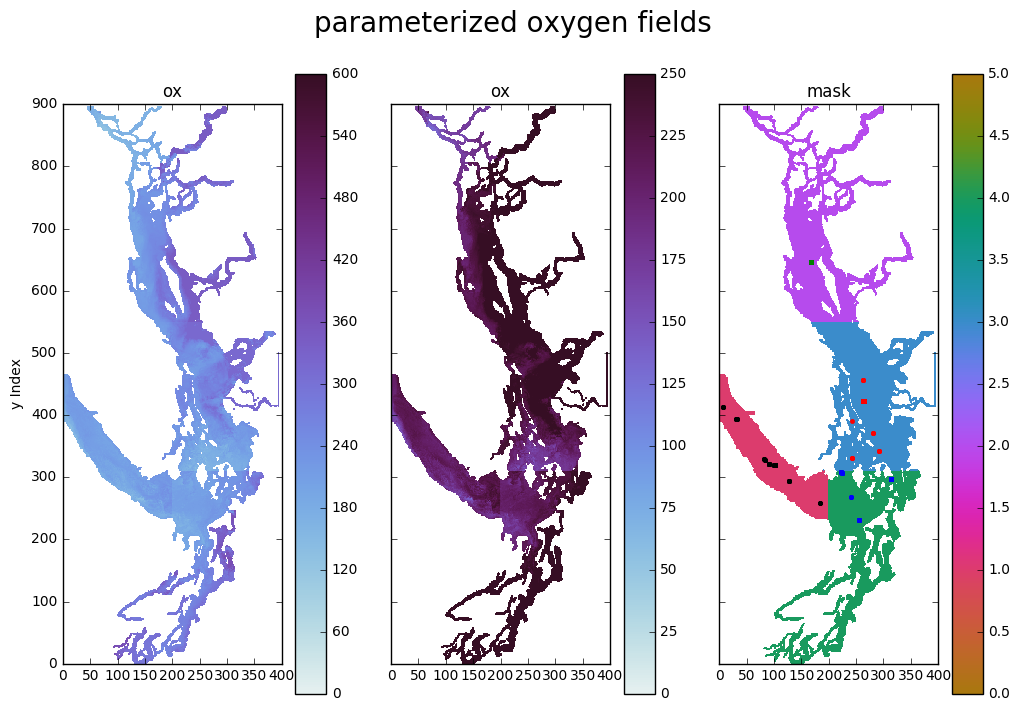

In [44]:

# DIC_masked = np.ma.masked_array(DIC, mask=tmask)
# ALK_masked = np.ma.masked_array(ALK, mask=tmask)
OX_s = OX_masked[0,5,:,:]


fig, axs = plt.subplots(1, 3, figsize=(12, 8), sharey=True)
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
    
time_steps = (0,1,2)
for ax, t in zip(axs, time_steps):
    if t == 0 :
        tplt = OX_s
        ax.set_title('ox')
        viz_tools.set_aspect(ax)
        mesh1 = ax.pcolormesh(tplt, cmap=cmocean.cm.dense, vmin = 0, vmax = 600)
    if t == 1 :
        tplt = OX_s
        ax.set_title('ox')
        viz_tools.set_aspect(ax)
        mesh1 = ax.pcolormesh(tplt, cmap=cmocean.cm.dense, vmin = 0, vmax = 250 )
    if t == 2 :
        tplt = surfmask
        ax.set_title('mask')
        viz_tools.set_aspect(ax)
        mesh1 = ax.pcolormesh(tplt, cmap=cmocean.cm.phase, vmin = 0, vmax = 5 )
        for w in range(0,860):
            j, i = geo_tools.find_closest_model_point(lon[w],lat[w],nav_lon,nav_lat)

            #JdF
            if  (i <200) & (j>220) & (j<500)  :
                tag[w] = 1
                ax.plot(i,j,'k.')
            #northern Strait
            if  (j >= 550) :
                tag[w] = 2
                ax.plot(i,j,'g.')
            # southern Strait    
            if (i> 150) & (j>310) & (j<550) :
                tag[w] = 3
                ax.plot(i,j,'r.')
                #puget
            if(i>=200) & (j<= 310):
                tag[w] = 4
                ax.plot(i,j,'b.')

    viz_tools.set_aspect(ax)
    #mesh = ax.pcolormesh(tplt, cmap=cmocean.cm.algae)
    cbar = fig.colorbar(mesh1, ax=ax)

#     ax.set_xlabel('x Index')
#     if t == 0:
#         cbar.set_label('DIC')
#     if t == 1:
#         cbar.set_label('ALK')
axs[0].set_ylabel('y Index')


plt.suptitle('parameterized oxygen fields',fontsize=20)

## create NC file and make sure it works

In [46]:
dsin = ds2

#output file
ncname = './init_DICTAOXY_Jan172019.nc'
dsout = nc.Dataset(ncname, "w", format="NETCDF4")
#Copy dimensions
for dname, the_dim in dsin.dimensions.items():
    print(dname)
    print(len(the_dim))
    dsout.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
# Copy variables
for v_name, varin in dsin.variables.items():
    outVar = dsout.createVariable(v_name, varin.datatype, varin.dimensions)
    print(varin.datatype)
    
    # Copy variable attributes
    outVar.setncatts({k: varin.getncattr(k) for k in varin.ncattrs()})
    
    outVar[:] = varin[:]

y
898
x
398
deptht
40
time_counter
1
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float64


In [47]:
print(dsout)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): y(898), x(398), deptht(40), time_counter(1)
    variables(dimensions): float32 tn(time_counter,deptht,y,x), float32 sn(time_counter,deptht,y,x), float32 TRNDON(time_counter,deptht,y,x), float32 TRNMICZ(time_counter,deptht,y,x), float32 TRNMYRI(time_counter,deptht,y,x), float32 TRNNH4(time_counter,deptht,y,x), float32 TRNNO3(time_counter,deptht,y,x), float32 TRNTRA(time_counter,deptht,y,x), float32 TRNPHY(time_counter,deptht,y,x), float32 TRNDIAT(time_counter,deptht,y,x), float32 TRNPON(time_counter,deptht,y,x), float32 TRNSi(time_counter,deptht,y,x), float32 TRNbSi(time_counter,deptht,y,x), float32 TRNDIC(time_counter,deptht,y,x), float32 TRNTA(time_counter,deptht,y,x), float64 TRNO2(time_counter,deptht,y,x)
    groups: 



In [ ]:
#OX = dsout.createVariable('TRNO2',np.float64,('time_counter','deptht','y','x'))


In [48]:

dsout['TRNO2'][:] = OX_masked[:]


## Plot nc file

In [ ]:
w = nc.Dataset(ncname)
q = w.variables['TRNO2']

In [ ]:
o2_test = q[:]
o2_t = o2_test[0,0,:,:]

fig, ax = plt.subplots(1, 1, figsize=(20, 16))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(o2_t, cmap=cmocean.cm.dense)
fig.colorbar(mesh)
plt.suptitle('o2 from new nc file',fontsize=20)

In [ ]:
DICdat = dsout.variables['TRNO2'][:]
DICdat.shape
print(DICdat[0,1,250,250])
q = np.where(DICdat <0)
print(q)

In [49]:
dsout.close()

In [50]:
w = nc.Dataset('./init_DICTAOXY_Jan172019.nc')
print(w)
w.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): y(898), x(398), deptht(40), time_counter(1)
    variables(dimensions): float32 tn(time_counter,deptht,y,x), float32 sn(time_counter,deptht,y,x), float32 TRNDON(time_counter,deptht,y,x), float32 TRNMICZ(time_counter,deptht,y,x), float32 TRNMYRI(time_counter,deptht,y,x), float32 TRNNH4(time_counter,deptht,y,x), float32 TRNNO3(time_counter,deptht,y,x), float32 TRNTRA(time_counter,deptht,y,x), float32 TRNPHY(time_counter,deptht,y,x), float32 TRNDIAT(time_counter,deptht,y,x), float32 TRNPON(time_counter,deptht,y,x), float32 TRNSi(time_counter,deptht,y,x), float32 TRNbSi(time_counter,deptht,y,x), float32 TRNDIC(time_counter,deptht,y,x), float32 TRNTA(time_counter,deptht,y,x), float64 TRNO2(time_counter,deptht,y,x)
    groups: 



In [52]:
w = nc.Dataset('./init_DICTAOXY_Jan172019.nc')
print(w)
w.variables['TRNO2'][0,:,250,250]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): y(898), x(398), deptht(40), time_counter(1)
    variables(dimensions): float32 tn(time_counter,deptht,y,x), float32 sn(time_counter,deptht,y,x), float32 TRNDON(time_counter,deptht,y,x), float32 TRNMICZ(time_counter,deptht,y,x), float32 TRNMYRI(time_counter,deptht,y,x), float32 TRNNH4(time_counter,deptht,y,x), float32 TRNNO3(time_counter,deptht,y,x), float32 TRNTRA(time_counter,deptht,y,x), float32 TRNPHY(time_counter,deptht,y,x), float32 TRNDIAT(time_counter,deptht,y,x), float32 TRNPON(time_counter,deptht,y,x), float32 TRNSi(time_counter,deptht,y,x), float32 TRNbSi(time_counter,deptht,y,x), float32 TRNDIC(time_counter,deptht,y,x), float32 TRNTA(time_counter,deptht,y,x), float64 TRNO2(time_counter,deptht,y,x)
    groups: 



masked_array(data = [215.2782440185547 215.2782440185547 215.2782440185547 213.19769287109375
 213.19769287109375 213.19769287109375 213.19769287109375
 213.19769287109375 213.19769287109375 213.19769287109375
 213.19769287109375 213.19769287109375 213.19769287109375
 213.19769287109375 213.19769287109375 213.19769287109375
 213.19769287109375 211.11705017089844 211.11705017089844
 211.11705017089844 206.9558563232422 200.71401977539062 184.0691375732422
 173.6661834716797 152.860107421875 152.860107421875 142.4570770263672
 142.4570770263672 -- -- -- -- -- -- -- -- -- -- -- --],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True],
       fill_value = 9.96920996839e+36)